In [1]:
import numpy as np
import numba
import Rebound_WTA_lib as WTA 
import importlib 
from matplotlib import pyplot as plt
importlib.reload(WTA)

<module 'Rebound_WTA_lib' from 'd:\\home\\tony\\Documents\\python\\WTA_snake_paper\\Rebound_WTA_lib.py'>

In [3]:
# Rebound bursting simulation for the requested ODE form

# ODE in the user's requested form


@numba.njit
def ss_Luka(x,u):
    dx=np.zeros(x.shape)
    # time-scale separation (slow and ultraslow)
    dx[:,1]=(-x[:,1]+x[:,0])/20.0      # tau_s = 50

    # passive leak
    leak=0.5*x[:,0]

    # localized conductance elements
    I_fast=-2*np.tanh(x[:,0]+1.5)  # fast negative conductance element
    I_slow= 2*np.tanh(x[:,1]+1.5)  # slow (+) and slow (–) combined
       # ultraslow restorative (+) element

    # membrane dynamics
    dx[:,0]=-leak-I_fast-I_slow+u[:,0]

    return dx

@numba.njit
def ss_Luka_slow(x,u,time=5,modulation=0.0):
    dx=np.zeros(x.shape)
    # time-scale separation (slow and ultraslow)
    dx[:,1]=(-x[:,1]+x[:,0])/3.0      # tau_s = 50
    dx[:,2]=(-x[:,2]+x[:,0])/20.0/time   # tau_us = 2500

    # passive leak
    leak=0.5*x[:,0]

    # localized conductance elements
    I_fast=-2.0*np.tanh(x[:,0]-3)                 # fast negative conductance element
    I_slow= 2.0*np.tanh(x[:,1]-3) -1.5*np.tanh(x[:,1]+1.5)  # slow (+) and slow (–) combined
    I_ultraslow=-(1.5-modulation)*np.tanh(x[:,2]+1.5)            # ultraslow restorative (+) element

    # membrane dynamics
    dx[:,0]=-leak-I_fast-I_slow+u[:,0]+I_ultraslow

    return dx

# Rebound bursting simulation for the requested ODE form

# ODE in the user's requested form
@numba.njit
def ss_Luka_bursting(x,u):
    dx=np.zeros(x.shape)
    # time-scale separation (slow and ultraslow)
    dx[:,1]=(-x[:,1]+x[:,0])/5.0      # tau_s = 50
    dx[:,2]=(-x[:,2]+x[:,0])/70.0    # tau_us = 2500

    # passive leak
    leak=0.5*x[:,0]

    # localized conductance elements
    I_fast=-2.0*np.tanh(x[:,0]-3)                 # fast negative conductance element
    I_slow= 2.0*np.tanh(x[:,1]-3) -1.5*np.tanh(x[:,1]+1.5)   # slow (+) and slow (–) combined
    I_ultraslow=-1.5*np.tanh(x[:,2]+1.5)            # ultraslow restorative (+) element

    # membrane dynamics
    dx[:,0]=-leak-I_fast-I_slow+u[:,0]+I_ultraslow

    return dx

# Simple forward-Euler simulator
@numba.njit
def simulate_rebound(sys,T=500.0, dt=0.05, base_current=-1.5, pulse_current=-5.0, t_on=150.0, t_off=300.0):
    n_steps = int(T/dt)
    t = np.arange(n_steps)*dt
    # input current: baseline + hyperpolarizing pulse
    u = np.ones((n_steps,1))*base_current
    u[(t>=t_on) & (t<t_off),0] = pulse_current

    # state: [V, V_s, V_us]
    x = np.zeros((1,3))
    X = np.zeros((n_steps,1,3))
    for k in range(n_steps):
        dx = sys(x, u[k:k+1,:])
        x = x + dt*dx
        X[k,:,:] = x
    return t, X, u


@numba.njit
def simulate_rebound_modulate(T=500.0, dt=0.05, base_current=-1.5, pulse_current=-5.0, t_on=150.0, t_off=300.0, modulation=0):
    n_steps = int(T/dt)
    t = np.arange(n_steps)*dt
    # input current: baseline + hyperpolarizing pulse
    u = np.ones((n_steps,1))*base_current
    u[(t>=t_on) & (t<t_off),0] = pulse_current

    # state: [V, V_s, V_us]
    x = np.zeros((1,3))
    X = np.zeros((n_steps,1,3))
    for k in range(n_steps):
        dx = ss_Luka_slow(x, u[k:k+1,:], modulation=modulation)
        x = x + dt*dx
        X[k,:,:] = x
    return t, X, u


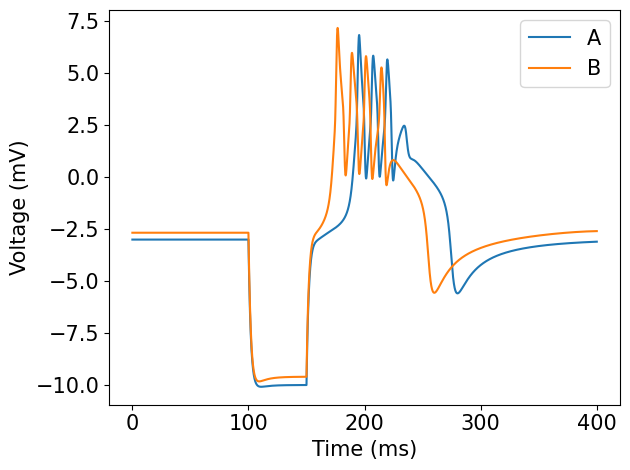

In [23]:
dt=0.05
t, X, u = simulate_rebound_modulate(T=10000,t_on=3000,t_off=3050,dt=dt,base_current=-1.5)
t_2, X_2, u_2 = simulate_rebound_modulate(T=10000,t_on=3000,t_off=3050,base_current=-1.5,dt=dt,modulation=-0.2)

outputs=X
outputs2=X_2

caption_size = 15
title_size   = 20
axis_size    = 15
start=int(2900/dt)
end=int(3300/dt)
data=np.array(outputs)[start:end,:,:]
data2=np.array(outputs2)[start:end,:,:]
length=data.shape[0]
plt.plot(np.linspace(0,length,length)*dt,data[:,:,0],label='A')
plt.plot(np.linspace(0,length,length)*dt,data2[:,:,0],label='B')
plt.ylabel('Voltage (mV)',fontsize=caption_size)
plt.xlabel('Time (ms)',fontsize=caption_size)
plt.tick_params(axis='both',labelsize=axis_size)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('bursting_neuron_2.png')

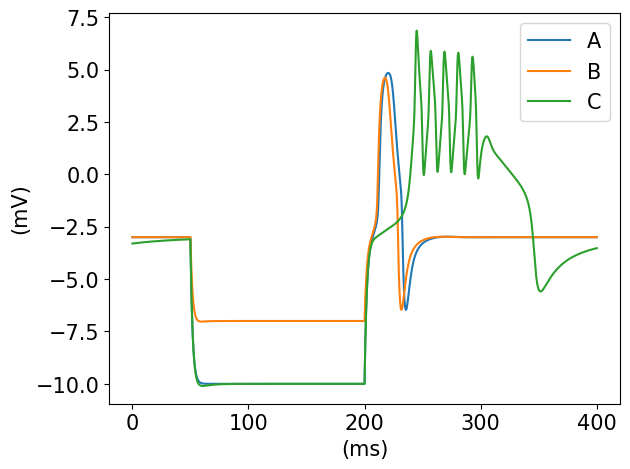

In [3]:

dt=0.05
t, X, u = simulate_rebound(ss_Luka,dt=dt)
t_2, X_2, u_2 = simulate_rebound(ss_Luka,pulse_current=-3.5,dt=dt)
t_3, X_3, u_3 = simulate_rebound(ss_Luka_slow,dt=dt)


outputs=X
outputs2=X_2
outputs3=X_3

caption_size = 15
title_size   = 20
axis_size    = 15
start=int(100/dt)
end=int(1000/dt)
data=np.array(outputs)[start:end,:,:]
data2=np.array(outputs2)[start:end,:,:]
data3=np.array(outputs3)[start:end,:,:]
length=data.shape[0]
plt.plot(np.linspace(0,length,length)*dt,data[:,:,0],label='A')
plt.plot(np.linspace(0,length,length)*dt,data2[:,:,0],label='B')
plt.plot(np.linspace(0,length,length)*dt,data3[:,:,0],label='C')
plt.ylabel('(mV)',fontsize=caption_size)
plt.xlabel('(ms)',fontsize=caption_size)
plt.tick_params(axis='both',labelsize=axis_size)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('spiking_neuron_3.png')

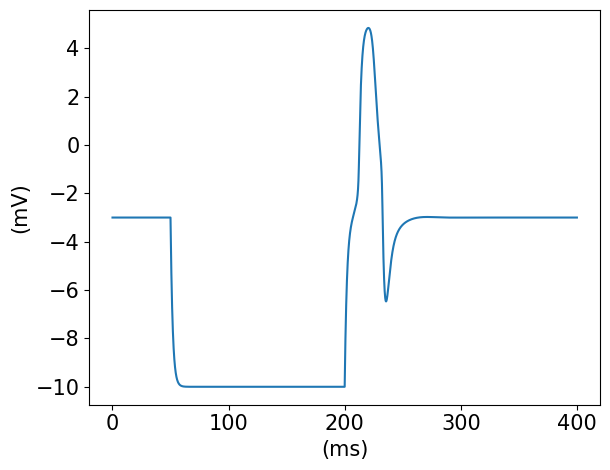

In [4]:

dt=0.05
t, X, u = simulate_rebound(ss_Luka,dt=dt)
t_2, X_2, u_2 = simulate_rebound(ss_Luka,pulse_current=-3.5,dt=dt)
t_3, X_3, u_3 = simulate_rebound(ss_Luka_slow,dt=dt)


outputs=X
outputs2=X_2
outputs3=X_3

caption_size = 15
title_size   = 20
axis_size    = 15
start=int(100/dt)
end=int(1000/dt)
data=np.array(outputs)[start:end,:,:]
data2=np.array(outputs2)[start:end,:,:]
data3=np.array(outputs3)[start:end,:,:]
length=data.shape[0]
plt.plot(np.linspace(0,length,length)*dt,data[:,:,0],label='A')
# plt.plot(np.linspace(0,length,length)*dt,data2[:,:,0],label='B')
# plt.plot(np.linspace(0,length,length)*dt,data3[:,:,0],label='C')
plt.ylabel('(mV)',fontsize=caption_size)
plt.xlabel('(ms)',fontsize=caption_size)
plt.tick_params(axis='both',labelsize=axis_size)
# plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('spiking_neuron_present.png')

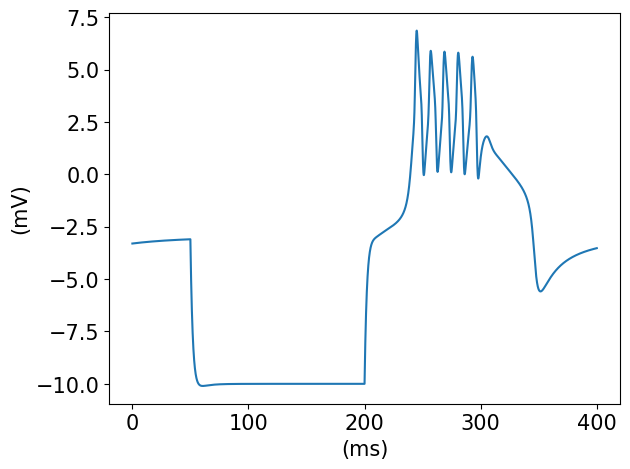

In [7]:
dt=0.05
t, X, u = simulate_rebound(ss_Luka,dt=dt)
t_2, X_2, u_2 = simulate_rebound(ss_Luka,pulse_current=-3.5,dt=dt)
t_3, X_3, u_3 = simulate_rebound(ss_Luka_slow,dt=dt)


outputs=X
outputs2=X_2
outputs3=X_3

caption_size = 15
title_size   = 20
axis_size    = 15
start=int(100/dt)
end=int(1000/dt)
data=np.array(outputs)[start:end,:,:]
data2=np.array(outputs2)[start:end,:,:]
data3=np.array(outputs3)[start:end,:,:]
length=data.shape[0]
# plt.plot(np.linspace(0,length,length)*dt,data[:,:,0],label='A')
# plt.plot(np.linspace(0,length,length)*dt,data2[:,:,0],label='B')
plt.plot(np.linspace(0,length,length)*dt,data3[:,:,0],label='C')
plt.ylabel('(mV)',fontsize=caption_size)
plt.xlabel('(ms)',fontsize=caption_size)
plt.tick_params(axis='both',labelsize=axis_size)
# plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('bursting_neuron_present.png')

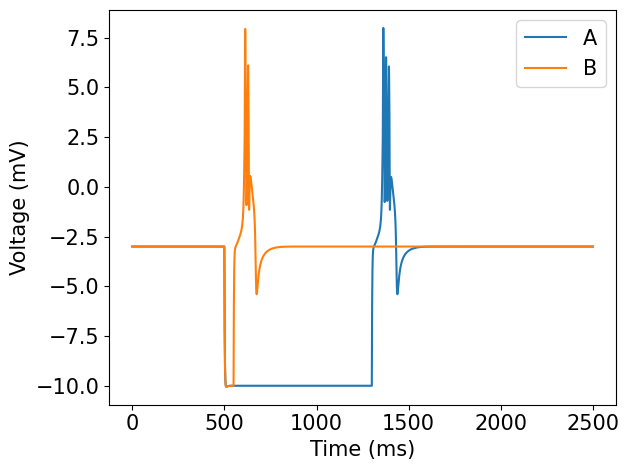

In [175]:
dt=0.05
t, X, u = simulate_rebound(ss_Luka_bursting,T=10000,t_on=3000,t_off=3800,dt=dt,base_current=-1.5)
t_2, X_2, u_2 = simulate_rebound(ss_Luka_bursting,T=10000,t_on=3000,t_off=3050,base_current=-1.5,dt=dt)

outputs=X
outputs2=X_2

caption_size = 15
title_size   = 20
axis_size    = 15
start=int(2500/dt)
end=int(5000/dt)
data=np.array(outputs)[start:end,:,:]
data2=np.array(outputs2)[start:end,:,:]
length=data.shape[0]
plt.plot(np.linspace(0,length,length)*dt,data[:,:,0],label='A')
plt.plot(np.linspace(0,length,length)*dt,data2[:,:,0],label='B')
plt.ylabel('Voltage (mV)',fontsize=caption_size)
plt.xlabel('Time (ms)',fontsize=caption_size)
plt.tick_params(axis='both',labelsize=axis_size)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('bursting_neuron_2.png')